In [19]:
#-- IMPORTING MODULES --
import numpy as np
import mpmath as mp

import math
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.optimize import fsolve
import scipy.misc
from scipy.misc import derivative
import scipy.interpolate
from scipy.interpolate import griddata
from scipy.integrate import quad, trapz, cumtrapz, romberg, fixed_quad, odeint, ode
from scipy import linalg
from numpy.linalg import inv
from scipy.special import gamma, hyp1f1
from scipy.interpolate import interp1d

#Atropy cosmology modules
import astropy.units as astrou
from astropy.cosmology import Planck18_arXiv_v2 as cosmo
from astropy.cosmology import z_at_value
from astropy.io import fits
from astropy.table import Table, Column, MaskedColumn

# Import mycode
import sys
path = '/Users/feixu/OneDrive - The University of Chicago/Documents/Research'
sys.path.append(path+'/mycode/')
sys.path.append(path+'/lensingFei/')
import gwfei
import constantfei 
#from detector_sensitivity_correct import *
from optical_depthfei import *
from RBBH_fei import *


#Plotting
from matplotlib.ticker import ScalarFormatter
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fontSz = 15
fontsz = 13
fontssz = 11

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

#Export results folder
import sys
dir_base=sys.path[0]
dir_out1=dir_base+"/plots_py_gw_lensing/"
dir_out2=dir_base+"/fits_py_gw_lensing/"

In [20]:
alpha = 0.4; M_min = 5; M_max = 41.6

def Prob_mass_distrib_norm_LIGO(m1):
    
    if m1 < M_min:
            norm = 0.
    elif m1 > M_max:
        norm = 0.
    else:
        norm = (alpha - 1.)/(M_min**(-1.*(alpha-1)) - M_max**(-1.*(alpha-1)))
    return norm * m1 **(-alpha)

Prob_mass_distrib_norm_LIGO = np.vectorize(Prob_mass_distrib_norm_LIGO)

In [21]:
def ITM(pdf, xrange, nrand):
    def cdf(x, pdf):
        return integrate.quad(lambda s: pdf(s), 0, x)[0]
    cdf = np.vectorize(cdf)
    
    t = np.random.uniform(0, 1, nrand)
    xl = np.linspace(xrange[0], xrange[1], num=100)
    spl0 = interpolate.interp1d(cdf(xl, pdf), xl, kind='linear', fill_value='extrapolate')
    
    return spl0(t)
    
    

In [22]:
cdf_pm = []

xl = np.linspace(M_min, M_max, num=100)

for x0 in xl:
    cdf_pm.append(integrate.quad(lambda s: Prob_mass_distrib_norm_LIGO(s), M_min, x0, points=[M_min, M_max])[0])
    #print(x0, cdf_pm[-1])

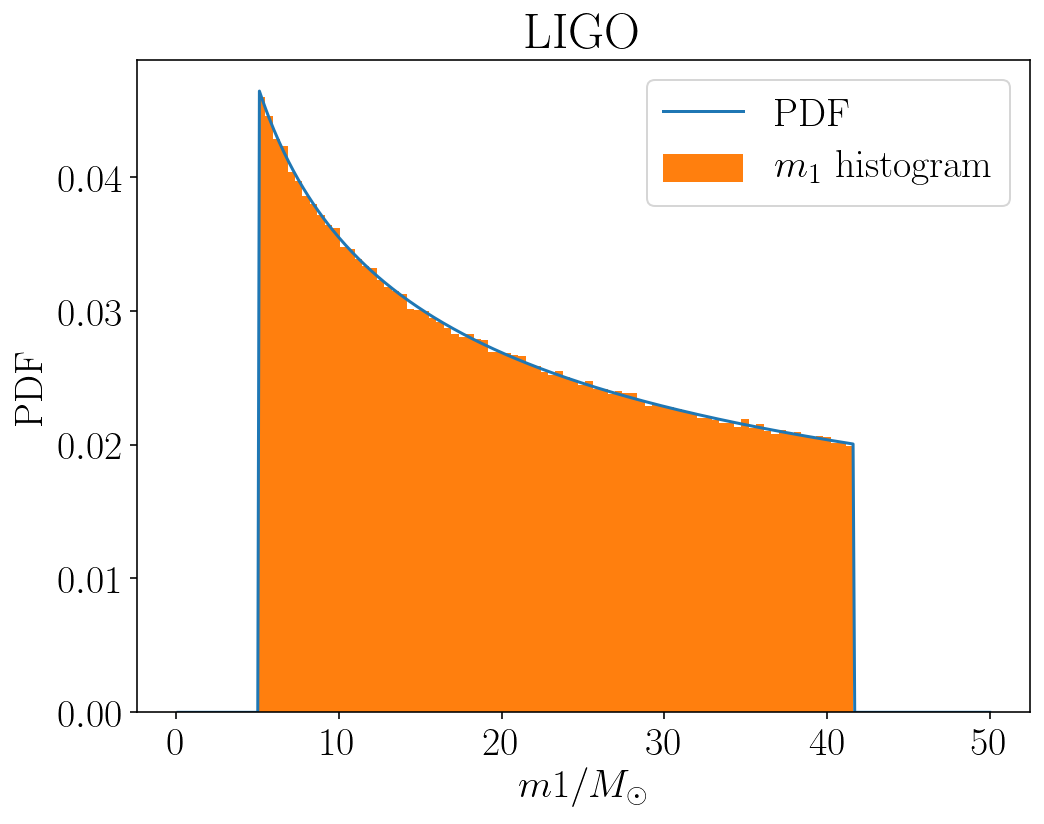

In [23]:
plt.figure(figsize=(8,6))

ml = np.linspace(0.1, 50, num=500)
pm1l = Prob_mass_distrib_norm_LIGO(ml)
plt.plot(ml, pm1l, label='PDF')
#plt.plot(ml, Prob_mass_distrib_m2_norm(ml, 15))

plt.xlabel('$m1 /M_\odot$', fontsize=20)
plt.ylabel('PDF', fontsize=20)

plt.xticks(size=20)
plt.yticks(size=20)

plt.title('LIGO', fontsize=25)

m1_rand = ITM(Prob_mass_distrib_norm_LIGO, [M_min, M_max], int(1e6))
plt.hist(m1_rand, bins=80, density=True, label='$m_1$ histogram');

#plt.ylim(0, 0.001)
plt.legend(fontsize=20)


In [25]:
integrate.quad(lambda x: Prob_mass_distrib_norm_LIGO(x), M_min, 20)[0], M_min

(0.5057842755592675, 5)

In [9]:
m2_rand = []
for m10 in m1_rand:
    m2_rand.append(np.random.uniform(M_min, m10, 1)[0])
m2_rand = np.array(m2_rand)

In [10]:
qratio_rand = m2_rand/m1_rand

In [11]:
Mchirp_rand = gwfei.mchirp(m1_rand, m2_rand)

35.984786246306875


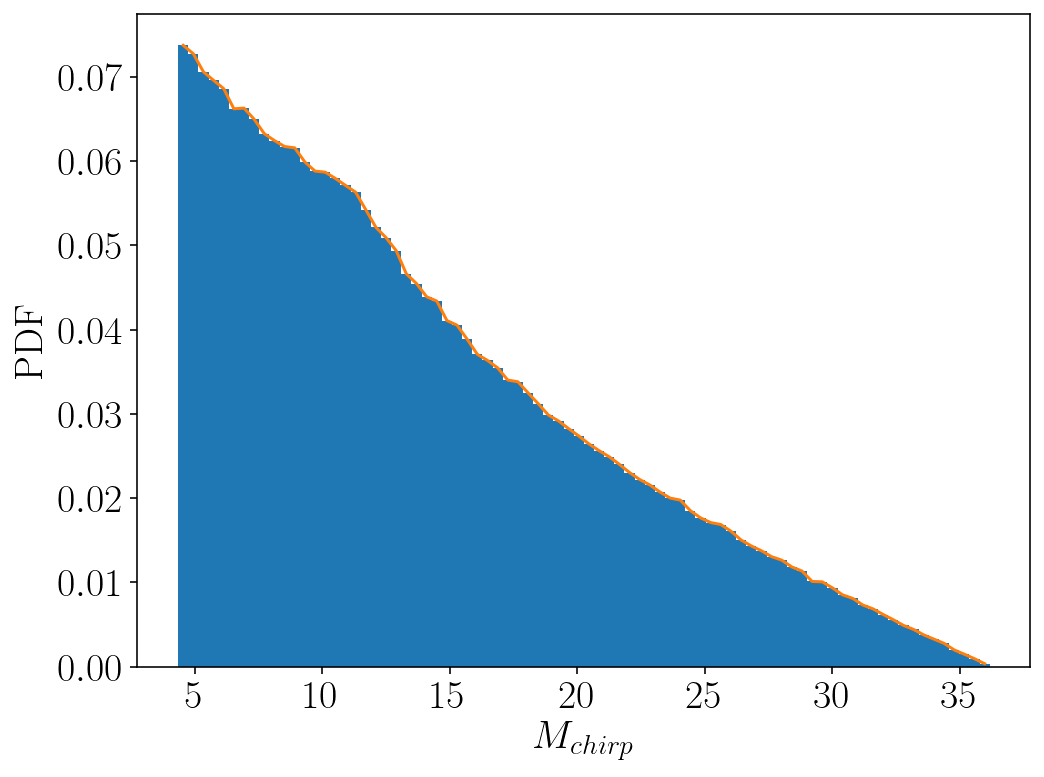

In [12]:
plt.figure(figsize=(8,6))

countschirp, binschirp = np.histogram(Mchirp_rand, density=True, bins=80)
plt.hist(Mchirp_rand, density=True, bins=80);


mbins = 0.5*(binschirp[1:]+binschirp[0:-1])
plt.plot(mbins, countschirp)


plt.xlabel('$M_{chirp}$', fontsize=20)
plt.ylabel('PDF', fontsize=20)

plt.xticks(size=20)
plt.yticks(size=20)

t = Table([mbins, countschirp], \
          names=['mbins', 'countschirp'], \
          masked=True)
#t.write(dir_out2+'PDF_Mchirpfei.fits', format='fits', overwrite=True) 

print(np.max(mbins))


### $\mathcal{M}_{chirp, min}, \mathcal{M}_{chirp, max}$

In [13]:
Mchirpmin = np.min(mbins); Mchirpmax = np.max(mbins)
print(Mchirpmin, Mchirpmax)

4.551731146814561 35.984786246306875


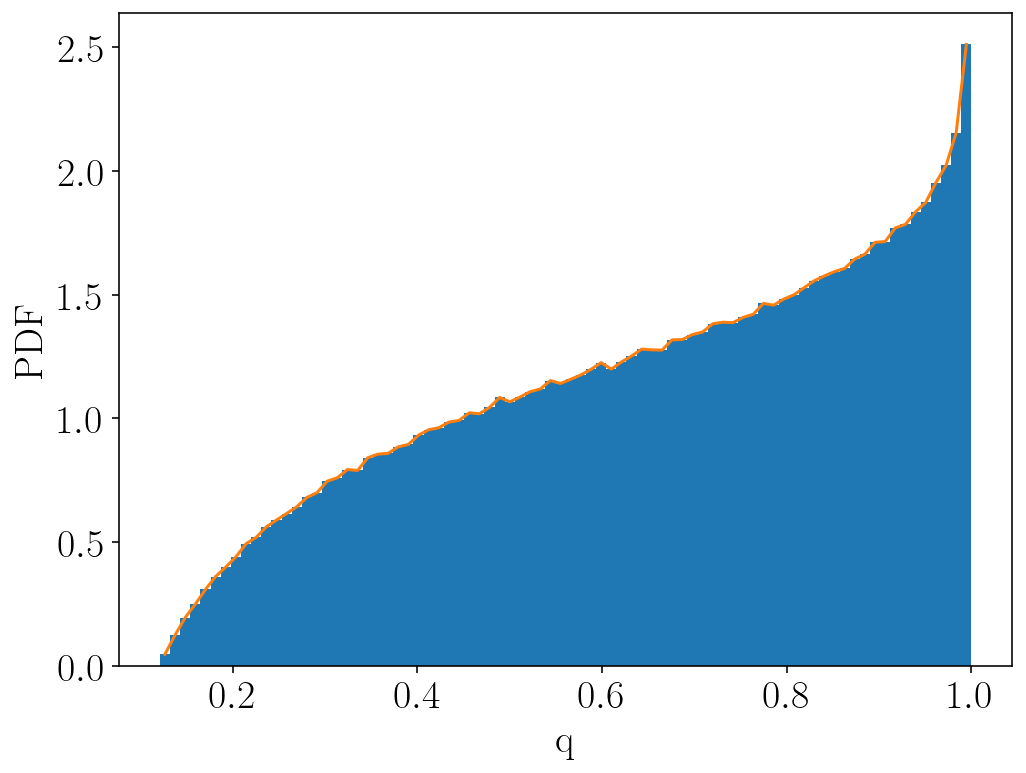

In [14]:
plt.figure(figsize=(8,6))

countschirp, binschirp = np.histogram(qratio_rand, density=True, bins=80)
plt.hist(qratio_rand, density=True, bins=80);


mbins = 0.5*(binschirp[1:]+binschirp[0:-1])
plt.plot(mbins, countschirp)


plt.xlabel('q', fontsize=20)
plt.ylabel('PDF', fontsize=20)

plt.xticks(size=20)
plt.yticks(size=20)


t = Table([mbins, countschirp], \
          names=['mbins', 'countschirp'], \
          masked=True)
#t.write(dir_out2+'PDF_qmassratiofei.fits', format='fits', overwrite=True) 


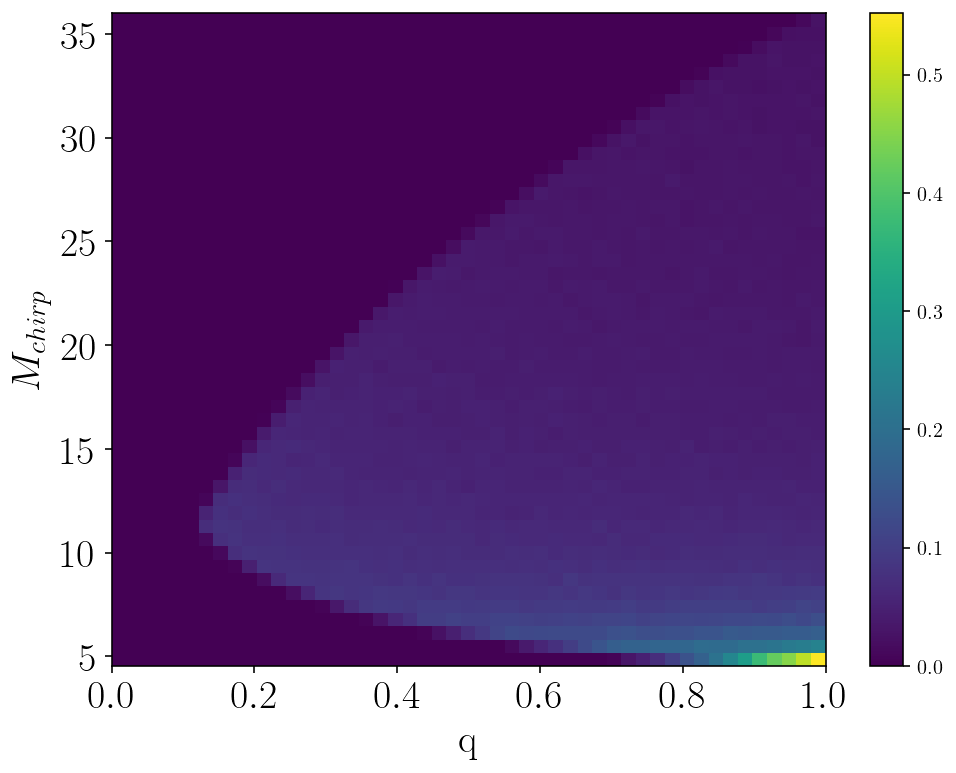

In [15]:
plt.figure(figsize=(8, 6))
PDFhist2d = plt.hist2d(qratio_rand, Mchirp_rand, density=True, bins =[np.linspace(0, 1, num=50), np.linspace(Mchirpmin, Mchirpmax, num=50)]) 
pdf_2d = PDFhist2d[0]; qratio_2d = 0.5*(PDFhist2d[1][0:-1]+PDFhist2d[1][1:]); mchirp_2d = 0.5*(PDFhist2d[2][0:-1]+PDFhist2d[2][1:])

plt.xticks(size=20)
plt.yticks(size=20)

plt.xlabel('q', fontsize=20)
plt.ylabel('$M_{chirp}$', fontsize=20)

plt.colorbar()


### Generate interpolated function 2d

In [16]:
Pchirpq_2d = interpolate.interp2d(mchirp_2d, qratio_2d, pdf_2d, kind='linear')

In [17]:
MCHIRP, QRATIO = np.meshgrid(mchirp_2d, qratio_2d)

In [18]:
t = Table([mchirp_2d, qratio_2d, pdf_2d], \
          names=['mchirp_2d', 'qratio_2d', 'pdf_2d'], \
          masked=True)
t.write(dir_out2+'Pchirpq_2Dfei.fits', format='fits', overwrite=True) 

### Check the interpolation function

In [43]:
PDF_2Dl = []
for qratio0 in qratio_2d:
    PDF_2Dl.append(Pchirpq_2d(mchirp_2d, qratio0))
        
PDF_2Dl = np.array(PDF_2Dl)

In [44]:
PDF_2Dl 

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.4426704 , 0.21443785, 0.15941404, ..., 0.03068933, 0.02565194,
        0.00061999],
       [0.48994438, 0.23032501, 0.15352417, ..., 0.02673692, 0.02689192,
        0.0136397 ],
       [0.52745356, 0.23342494, 0.16638889, ..., 0.02689192, 0.02836438,
        0.02720191]])

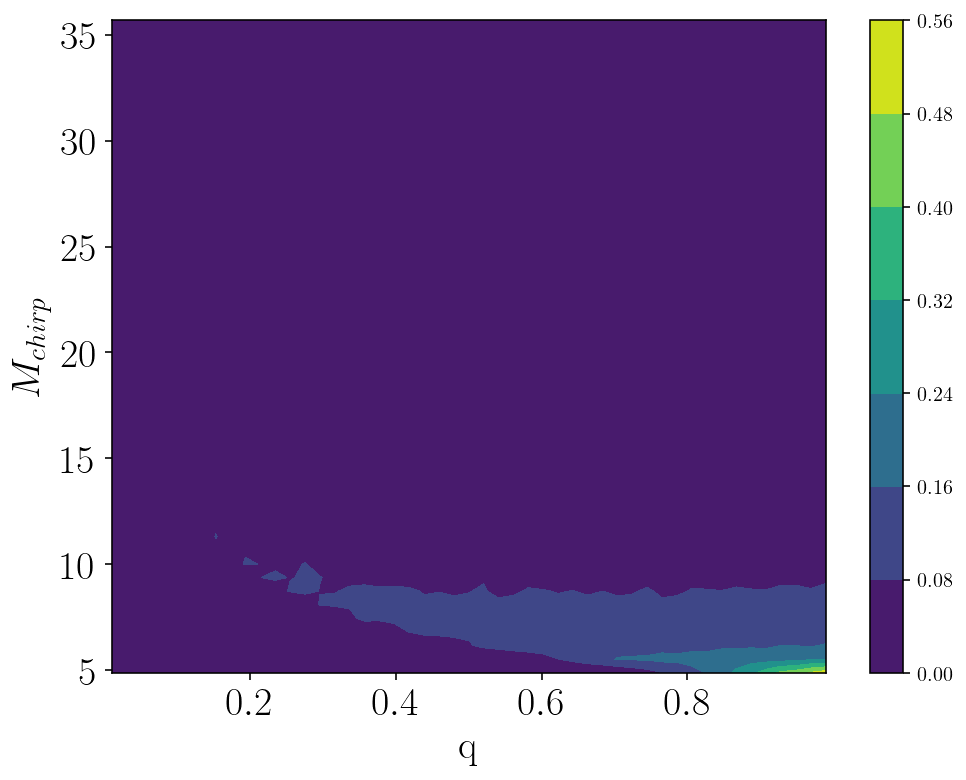

In [45]:
plt.figure(figsize=(8, 6))
plt.contourf(qratio_2d, mchirp_2d, np.transpose(PDF_2Dl))

plt.xticks(size=20)
plt.yticks(size=20)

plt.xlabel('q', fontsize=20)
plt.ylabel('$M_{chirp}$', fontsize=20)

plt.colorbar()